# Detection with SSD

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '/home/kaliev/sources/caffe-ssd-nexar'
import os
import sys
sys.path.insert(0, os.path.join(caffe_root, 'python'))

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

* Disable scrolling output

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

* Load LabelMap.

In [3]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load Nexar labels
labelmap_file = os.path.join(caffe_root, 'data/nexar2/labelmap.prototxt')
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

In [4]:
model_def = 'models/SSD/VGG16/2/deploy.prototxt'
model_weights = 'models/SSD/VGG16/2/VGG_nexar2_SSD_512x512_iter_120000.caffemodel'

net = None
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

### 2. SSD detection

* Load an image.

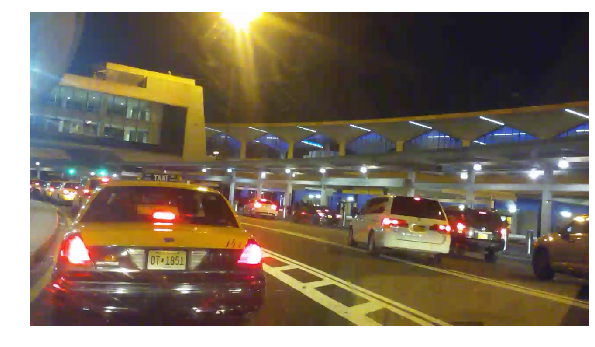

In [6]:
# set net to batch size of 1
image_resize = 512
net.blobs['data'].reshape(1,3,image_resize,image_resize)

image = caffe.io.load_image('examples/8.jpg')
plt.imshow(image)
plt.axis('off');

* Run the net and examine the top_k results

In [7]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = transformed_image

# Forward pass.
detections = net.forward()['detection_out']

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

pred_nonbackg = True
conf_thresh = 0.4

# Get detections with confidence higher than some threshold.
top_indices = []
for i in range(det_conf.shape[0]):
    if det_conf[i] >= conf_thresh and (not pred_nonbackg or det_label[i] == 0):
        top_indices.append(i)

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


* Plot the boxes

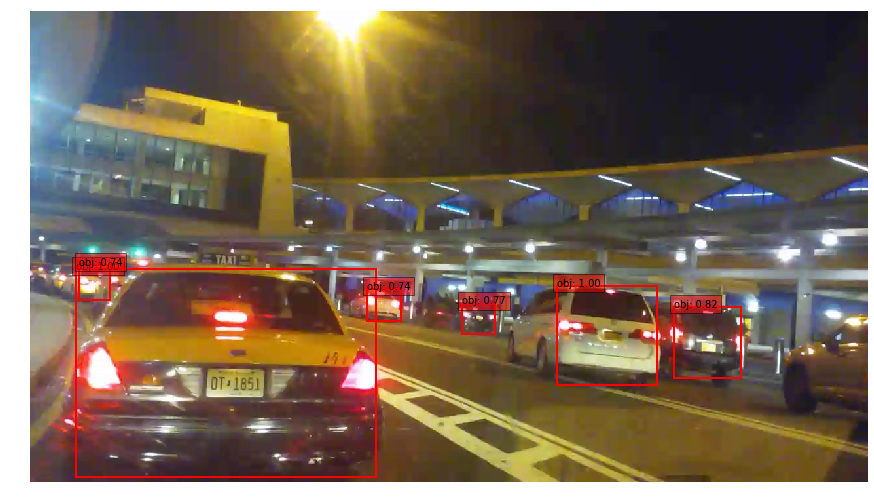

In [8]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(15,10))
plt.imshow(image)
plt.axis('off')
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    if not pred_nonbackg and label == 0: continue
    label_name = 'obj' if pred_nonbackg and label == 0 else top_labels[i]
    display_txt = '%s: %.2f'%(label_name, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    #print '%s: %.2f'%(label_name, score)

## Evaluate on Nexar validation set

In [125]:
import pandas as pd
from collections import defaultdict

# path to the validation images folder
val_image_root = os.path.abspath('./data/train')

val_anno_df = pd.read_csv('./val.csv')

In [126]:
max_val_num = 0

val_names = list(set(val_anno_df['image_filename']))

det_dict = defaultdict(list)

pred_nonbackg = True
conf_thresh = 0.05

coord_func = lambda x: round(x)

max_val_num = max_val_num if max_val_num > 0 else len(val_names)
for iname in range(max_val_num):
    # load & transform image
    name = val_names[iname]
    image_path = os.path.join(val_image_root, name)
    image = caffe.io.load_image(image_path)
    transformed_image = transformer.preprocess('data', image)
    
    # detect
    net.blobs['data'].data[...] = transformed_image
    detections = net.forward()['detection_out']
    
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]

    conf_mask = det_conf >= conf_thresh
    label_mask = det_label == 0 if pred_nonbackg else det_label != 0

    h, w = image.shape[:2]
    for ind in np.nonzero(np.bitwise_and(conf_mask, label_mask))[0]:
        det_dict['image_filename'].append(name)
        x0 = coord_func(w * det_xmin[ind])
        y0 = coord_func(h * det_ymin[ind])
        x1 = coord_func(w * det_xmax[ind])
        y1 = coord_func(h * det_ymax[ind])
        det_dict['x0'].append(x0)
        det_dict['y0'].append(y0)
        det_dict['x1'].append(x1)
        det_dict['y1'].append(y1)        
        label = 'car' if pred_nonbackg else get_labelname(labelmap, det_label[ind])[0]
        det_dict['label'].append(label)
        det_dict['confidence'].append(det_conf[ind])
        
    if iname > 0 and iname % 100 == 0: 
        print('%s/%s'%(iname,max_val_num))
        
    if iname == max_val_num - 1:
        break
        
val_det_df = pd.DataFrame(det_dict, columns=['image_filename','x0','y0','x1','y1','label','confidence'])
val_det_df.to_csv('val_det.csv', index=False)

print('Done')

100/10000
200/10000
300/10000
400/10000
500/10000
600/10000
700/10000
800/10000
900/10000
1000/10000
1100/10000
1200/10000
1300/10000
1400/10000
1500/10000
1600/10000
1700/10000
1800/10000
1900/10000
2000/10000
2100/10000
2200/10000
2300/10000
2400/10000
2500/10000
2600/10000
2700/10000
2800/10000
2900/10000
3000/10000
3100/10000
3200/10000
3300/10000
3400/10000
3500/10000
3600/10000
3700/10000
3800/10000
3900/10000
4000/10000
4100/10000
4200/10000
4300/10000
4400/10000
4500/10000
4600/10000
4700/10000
4800/10000
4900/10000
5000/10000
5100/10000
5200/10000
5300/10000
5400/10000
5500/10000
5600/10000
5700/10000
5800/10000
5900/10000
6000/10000
6100/10000
6200/10000
6300/10000
6400/10000
6500/10000
6600/10000
6700/10000
6800/10000
6900/10000
7000/10000
7100/10000
7200/10000
7300/10000
7400/10000
7500/10000
7600/10000
7700/10000
7800/10000
7900/10000
8000/10000
8100/10000
8200/10000
8300/10000
8400/10000
8500/10000
8600/10000
8700/10000
8800/10000
8900/10000
9000/10000
9100/10000
9200/100

In [127]:
!python challenge2-evaluation/evaluate/eval_challenge.py -g ./val.csv -d ./val_det.csv

Ground truth: cvs - ./val.csv , Number images = 10000
Detector: cvs - ./val_det.csv , Number images= 10000
Number of empty GT images: 0
0.716858545167
